In [1]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
config.update("jax_enable_x64", True)

# Set parameters.

In [2]:
# Parameters.
x_dimension = 2
y_dimension = 2
n_up = 2
n_down = 2

n_site = x_dimension * y_dimension

U = 4
t = 1.0
t_prime = 0.3
mu = 0.0

## Construct the reduced Hamiltonian.

In [3]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

In [4]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):

    spin_up_indices = bits[::2]
    spin_down_indices = bits[1::2]

    if spin_up_indices.count('1') == n_up and spin_down_indices.count('1') == n_down:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 36
Eigenvalues: [-5.657 -5.372 -4.374 -3.901 -3.901 -3.254 -1.716 -1.716]


In [7]:
U_sweep_ED = jnp.linspace(0, U, 80)

H_eigvals_sweep = []
H_eigvecs_sweep = []

for UU in U_sweep_ED:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals, eigvecs = jnp.linalg.eigh(H)
    H_eigvals_sweep.append(eigvals)
    H_eigvecs_sweep.append(eigvecs)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T
H_eigvecs_sweep = jnp.array(H_eigvecs_sweep)

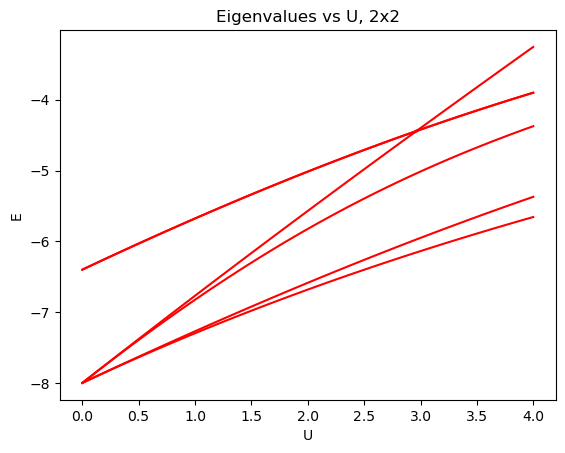

In [6]:
for band in range(6):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')


plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

In [37]:
Fidelity_sweep0 = [jnp.abs(jnp.real(H_eigvecs_sweep[-1, :, 0]@H_eigvecs_sweep[idx, :, 0])) for idx in range(len(U_sweep_ED))]
Fidelity_sweep1 = [jnp.abs(jnp.real(H_eigvecs_sweep[-1, :, 1]@H_eigvecs_sweep[idx, :, 1])) for idx in range(len(U_sweep_ED))]
Fidelity_sweep2 = [jnp.abs(jnp.real(H_eigvecs_sweep[-1, :, 2]@H_eigvecs_sweep[idx, :, 2])) for idx in range(len(U_sweep_ED))]

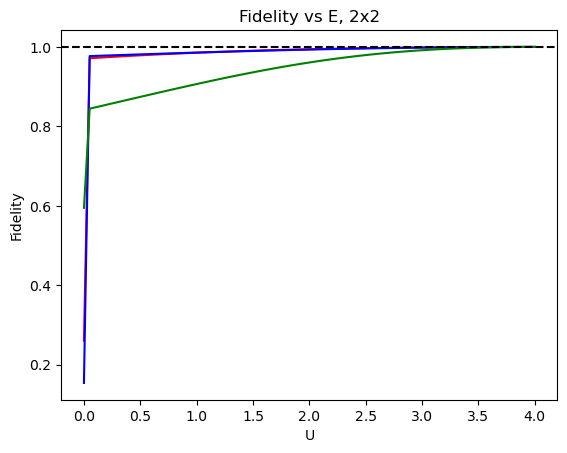

In [46]:
plt.plot(U_sweep_ED, Fidelity_sweep0, 'red')
plt.plot(U_sweep_ED, Fidelity_sweep1, 'blue')
plt.plot(U_sweep_ED, Fidelity_sweep2, 'green')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('U')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs E, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

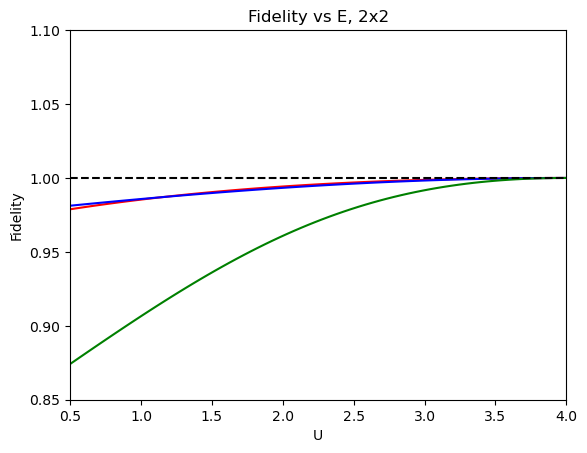

In [47]:
plt.plot(U_sweep_ED, Fidelity_sweep0, 'red')
plt.plot(U_sweep_ED, Fidelity_sweep1, 'blue')
plt.plot(U_sweep_ED, Fidelity_sweep2, 'green')

plt.axhline(y=1, color='black', linestyle='--')
plt.xlim(0.5, 4)
plt.ylim(0.85, 1.1)
plt.xlabel('U')
plt.ylabel('Fidelity')
plt.title(f'Fidelity vs E, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()